In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Reading the data

In [2]:
df = pd.read_csv(os.path.abspath('../data/Nal_filtre_FLX_NEE_01012011_31122017.csv'), encoding = "ISO-8859-1", sep = ';')
df.columns = df.iloc[0] # fix the col names to be the 1st col
df = df.iloc[1:] # fix the col names to be the 1st col

/tmp/ipykernel_36924/2543690903.py:1: DtypeWarning: Columns (0,2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.abspath('../data/Nal_filtre_FLX_NEE_01012011_31122017.csv'), encoding = "ISO-8859-1", sep = ';')


In [3]:
df.head(3)

,heure,DateUTC,NEE,Ustar,Swin,T_meteo,VPD,Tsol1_10,Hv1,Hv2
1,0,01/01/2011 00:00,NaN,0.23159,NaN,NaN,NaN,NaN,0.038,0.056
2,0.5,01/01/2011 00:30,NaN,0.20874,-3.113,18.64,1.569496568,27.385,0.038,0.056
3,1,01/01/2011 01:00,NaN,0.17778,-3.181,17.785,1.453069295,27.14,0.038,0.056


---

### Convert to Numpy

In [4]:
X = df.iloc[:,2:].values
X = X.astype(float)
print(X.shape)

(122736, 8)


---

### Standardization

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

---

### Outliers Removal

In [6]:
Xout = np.abs(X)>3 # we tried with 4, but the number was still so big
X[Xout] = float("nan")
X[Xout] = float("nan")

---

### Tensor

In [7]:
X = X[:365 * (len(X)//365) ,] # we are removing the extra days
print(X.shape)
X_tensor = np.reshape(X, (7, -1,8 )) 
print(X_tensor.shape) # (t, rows, cols)
print(X_tensor[0][0])

(122640, 8)
(7, 17520, 8)
[        nan  0.0355321          nan         nan         nan         nan
 -0.89768305 -0.93539032]


---

### Seasonality

In [8]:
Xseason = np.nanmean(X_tensor, axis = 0) # so we took the avrage across 7 years
print(Xseason.shape)
print(Xseason[0])

(17520, 8)
[ 0.33218283 -0.53776708 -0.73200605 -0.6123935   0.25814608 -0.45556883
 -0.91664538 -0.93539032]


/tmp/ipykernel_36924/1513193925.py:1: RuntimeWarning: Mean of empty slice
  Xseason = np.nanmean(X_tensor, axis = 0) # so we took the avrage across 7 years


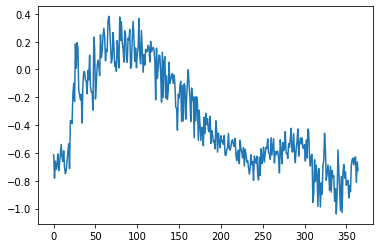

In [9]:
plt.plot(Xseason[::48,3])

---

### Smoothing

In [49]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import scipy.signal
from PyAstronomy import pyasl
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

(17520,)


/users/hussein/source/imputation/vImp/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


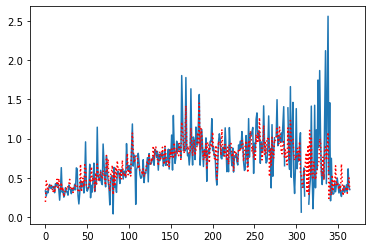

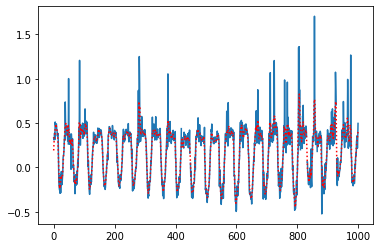

(17520,)


/users/hussein/source/imputation/vImp/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


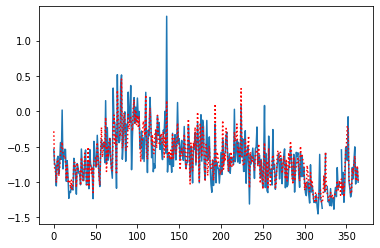

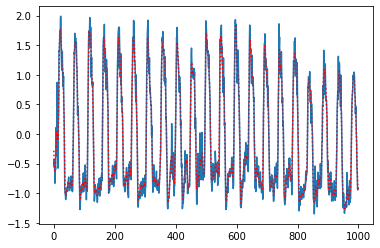

(17520,)


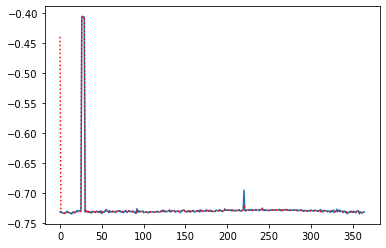

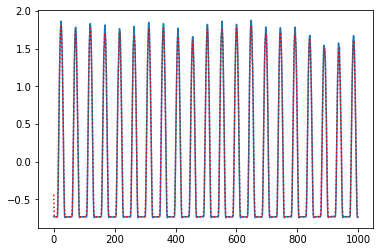

(17520,)


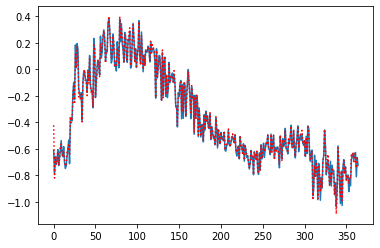

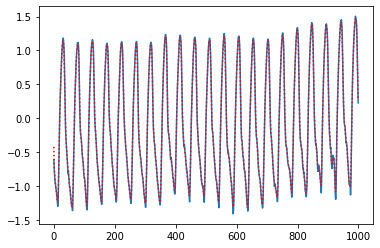

(17520,)


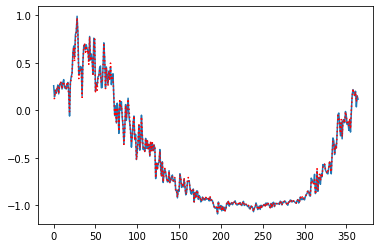

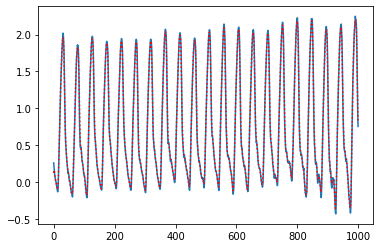

(17520,)


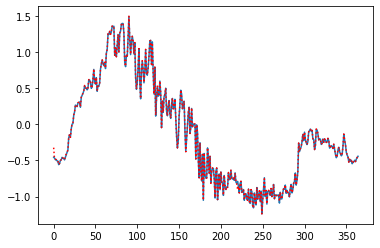

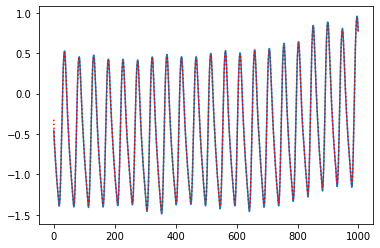

(17520,)


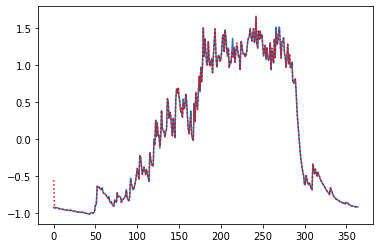

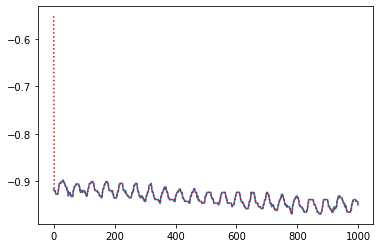

(17520,)


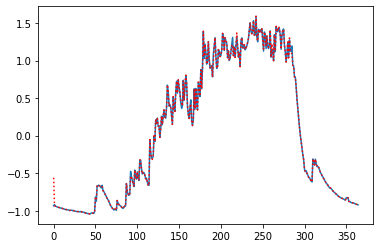

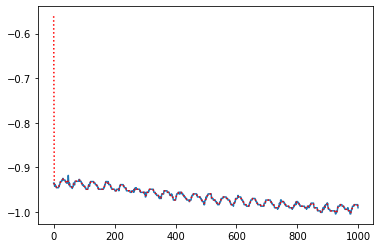

In [51]:
m = 12
alpha = 1/(2*m)

for i in range (8):

    
    fit1 = SimpleExpSmoothing(np.asarray(Xseason[:,i])).fit().fittedvalues
    yhat = scipy.signal.savgol_filter(Xseason[:,i], 50, 3, mode='nearest')
    sm2 = pyasl.smooth(Xseason[:,i], 7, 'hamming')
    
    box = Box1DKernel(5)
    smoothed_gauss = convolve(Xseason[:,i], box)
    print(fit1.shape)
    plt.plot(Xseason[::48,i])
    # plt.plot(sm2[::48], 'r--')
    plt.plot(smoothed_gauss[::48], 'r:')
    
    # plt.plot(yhat[::48], 'r:', lw=2)
    # plt.plot(fit1[::48], 'y-', lw=2)
    
    

    plt.show()
    plt.plot(Xseason[0:1000,i])
    plt.plot(smoothed_gauss[0:1000], 'r:')
    # plt.plot(sm2[0:1000], 'r--')
    plt.show()

---

#### Removing Seasonality

In [12]:
XClean_tensor = X_tensor - Xseason
print(XClean_tensor.shape)
print(XClean_tensor[0][0])

(7, 17520, 8)
[           nan 5.73299177e-01            nan            nan
            nan            nan 1.89623302e-02 1.11022302e-16]


In [13]:
0.0355321-(-0.53776708)

0.5732991799999999

### Create The data

In [14]:
XClean_np = np.reshape(XClean_tensor, (-1,8) )
XClean_df = pd.DataFrame(XClean_np, columns = df.columns[2:])


In [15]:
XClean_df

,NEE,Ustar,Swin,T_meteo,VPD,Tsol1_10,Hv1,Hv2
0,NaN,0.573299,NaN,NaN,NaN,NaN,0.018962,1.110223e-16
1,NaN,0.305922,-0.004173,-0.381933,-0.193158,-0.104793,0.022755,1.110223e-16
2,NaN,0.111600,-0.003097,-0.432981,-0.219921,-0.104099,0.022755,1.110223e-16
3,NaN,0.257217,-0.001565,-0.385913,-0.196866,-0.107106,0.022755,6.913543e-03
4,NaN,0.650464,-0.001658,-0.327528,-0.165273,-0.115434,0.022755,6.913543e-03
...,...,...,...,...,...,...,...,...
122635,NaN,NaN,-0.006003,0.432374,0.207754,NaN,-0.011377,3.456772e-02
122636,NaN,NaN,-0.003729,0.275716,0.090948,NaN,-0.011377,3.802449e-02
122637,NaN,NaN,-0.001893,0.240529,0.058388,NaN,-0.007585,3.802449e-02
122638,NaN,NaN,0.000560,0.260022,0.059046,NaN,-0.007585,3.802449e-02


In [16]:
import sys

# append the path of the
# parent directory
sys.path.append("..")
from source.utils import create_dic, create_comb, creat_lags

In [27]:
Xlagged_df = creat_lags(XClean_df, df.columns[2:])

In [29]:
Xlagged_df.values[0]

array([            nan,             nan,             nan,             nan,
                   nan,  5.73299177e-01,             nan,  3.05921968e-01,
                   nan,  3.57249697e-01,             nan,             nan,
       -4.17343206e-03,             nan,  2.93488353e-03,             nan,
                   nan, -3.81932608e-01,             nan,  6.47547743e-02,
                   nan,             nan, -1.93158071e-01,             nan,
       -1.60265933e-03,             nan,             nan, -1.04792680e-01,
                   nan,  6.80111432e-02,  1.89623302e-02,             nan,
        2.27547962e-02,             nan,  2.65472623e-02,  1.11022302e-16,
                   nan,  1.11022302e-16,             nan, -4.03290012e-03])

In [32]:
import numpy as np
test = np.random.rand(365*7*48,8)
# Pad with nan
test1 = np.pad(test, ((49,49),(0,0)),mode='constant',constant_values = (np.nan,np.nan))
test_select = np.concatenate((test1[49:-49,:],test1[0:-98,:],
                              test1[98:,:],test1[48:-50,:],
                             test1[50:-48,:]),axis=1)

In [33]:
test_select[0]

array([0.85673404, 0.38018965, 0.0865118 , 0.77361406, 0.57771701,
       0.86969328, 0.45749072, 0.54778843,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.33111164, 0.77759514, 0.31184118, 0.6331943 ,
       0.26275079, 0.24441603, 0.16637957, 0.13398018,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.43965219, 0.05219466, 0.8110613 ,
       0.53626176, 0.4715453 , 0.96410226, 0.75858156, 0.88082099])

In [34]:
test_df = pd.DataFrame(test, columns = df.columns[2:])


In [35]:
test_select_df = creat_lags(test_df, df.columns[2:])

In [36]:
test_select_df.values[0]

array([0.85673404,        nan, 0.43965219,        nan, 0.33111164,
       0.38018965,        nan, 0.05219466,        nan, 0.77759514,
       0.0865118 ,        nan, 0.8110613 ,        nan, 0.31184118,
       0.77361406,        nan, 0.53626176,        nan, 0.6331943 ,
       0.57771701,        nan, 0.4715453 ,        nan, 0.26275079,
       0.86969328,        nan, 0.96410226,        nan, 0.24441603,
       0.45749072,        nan, 0.75858156,        nan, 0.16637957,
       0.54778843,        nan, 0.88082099,        nan, 0.13398018])